# Домашняя работа 8. Деревья решений. (32 балла)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #8: Name Surname`. Если тема будет неправильная, то задание не будет проверено.
6. Дедлайн: 18.12.2017 01:00 OMSK
7. После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

Рассылка решений: 25.12.2017 17:00 OMSK
После рассылки задания почти совсем не имеют веса.

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиции деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'../../data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

In [235]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

In [236]:
from warnings import filterwarnings
filterwarnings('ignore')

In [426]:
wine = pd.read_csv('data/winequality-red.csv.gz', sep=';', compression='gzip')
wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


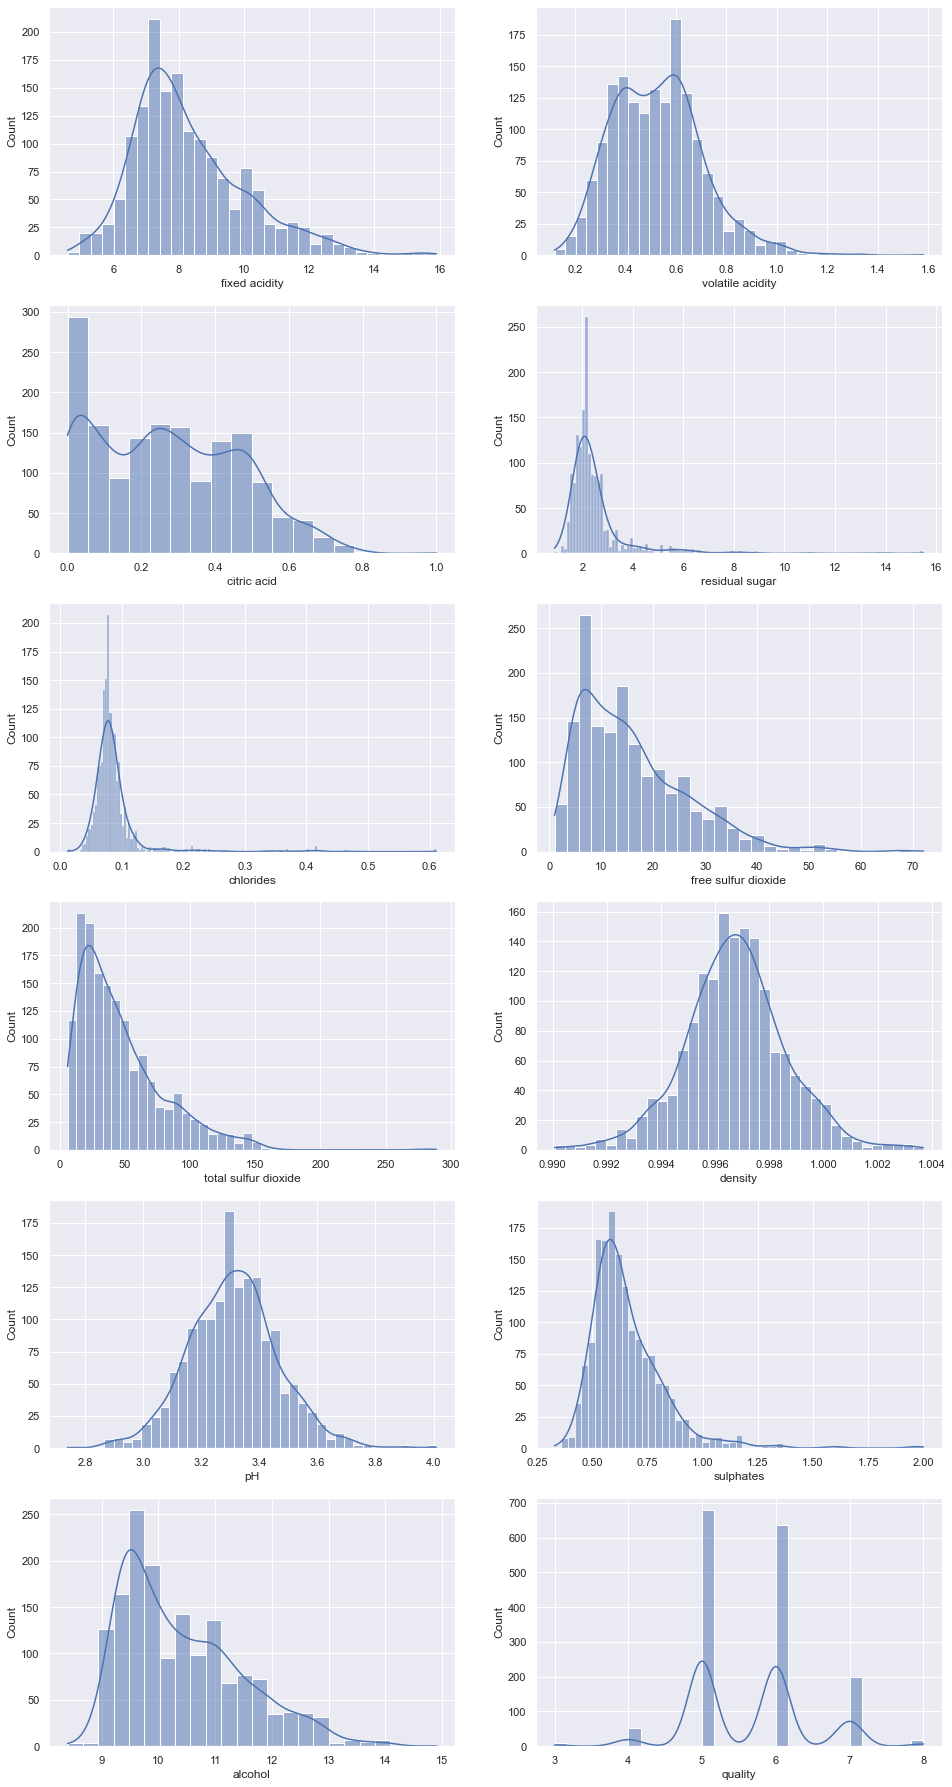

In [238]:
fig, axes = plt.subplots(6, 2, figsize=(16, 32))
for i in range(6):
    for j in range(2):
        sns.histplot(data=wine, x=wine.columns[2*i + j], kde=True, ax=axes[i, j])

In [239]:
# an attempt of getting normal distribution

initially_okay = ['density', 'pH', 'quality']
better_with_log = ['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']
better_with_two_logs = ['fixed acidity', 'residual sugar']
just_bad = ['citric acid', 'alcohol']

<AxesSubplot:xlabel='quality', ylabel='count'>

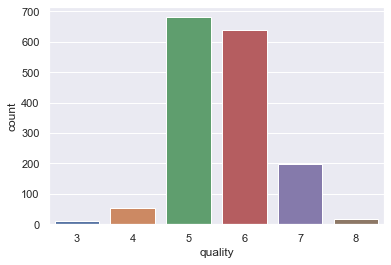

In [240]:
sns.set()
sns.countplot(data=wine, x='quality')

In [412]:
X, y = wine.drop(columns='quality'), wine.quality

### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier 
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов. 

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [411]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

In [413]:
means = []

KNeighborsClassifier_ = KNeighborsClassifier(n_neighbors=10)
score = cross_val_score(KNeighborsClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"KNeighborsClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

StandardScaler_ = StandardScaler()
X_scaled = StandardScaler_.fit_transform(X)
KNeighborsClassifierSS_ = KNeighborsClassifier(n_neighbors=10)
score = cross_val_score(KNeighborsClassifierSS_, X_scaled, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"KNeighborsClassifier, scaled data: {', '.join(map(str, score))}, mean: {score.mean()}")

RidgeClassifier_ = RidgeClassifier(random_state=42)
score = cross_val_score(RidgeClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"RidgeClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

DecisionTreeClassifier_ = DecisionTreeClassifier(random_state=42)
score = cross_val_score(DecisionTreeClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"DecisionTreeClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

BaggingClassifier_ = BaggingClassifier(n_estimators=100, random_state=42)
score = cross_val_score(BaggingClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"BaggingClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

BaggingClassifierHalfF_ = BaggingClassifier(n_estimators=100, max_features=0.5, random_state=42)
score = cross_val_score(BaggingClassifierHalfF_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"BaggingClassifier, half features: {', '.join(map(str, score))}, mean: {score.mean()}")

BaggingClassifierHalfS_ = BaggingClassifier(n_estimators=100, max_samples=0.5, random_state=42)
score = cross_val_score(BaggingClassifierHalfS_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"BaggingClassifier, half samples: {', '.join(map(str, score))}, mean: {score.mean()}")

RandomForestClassifier_ = RandomForestClassifier(n_estimators=100, random_state=42)
score = cross_val_score(RandomForestClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"RandomForestClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

GradientBoostingClassifier_ = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=1, random_state=42)
score = cross_val_score(GradientBoostingClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"GradientBoostingClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

KNeighborsClassifier: 0.5, 0.403125, 0.496875, 0.4, 0.445141065830721, mean: 0.44902821316614416
KNeighborsClassifier, scaled data: 0.5375, 0.53125, 0.615625, 0.51875, 0.542319749216301, mean: 0.5490889498432602
RidgeClassifier: 0.61875, 0.496875, 0.584375, 0.5625, 0.6144200626959248, mean: 0.575384012539185
DecisionTreeClassifier: 0.490625, 0.475, 0.4, 0.41875, 0.47335423197492166, mean: 0.45154584639498435
BaggingClassifier: 0.565625, 0.54375, 0.58125, 0.55, 0.5799373040752351, mean: 0.564112460815047
BaggingClassifier, half features: 0.621875, 0.51875, 0.55, 0.51875, 0.5705329153605015, mean: 0.5559815830721003
BaggingClassifier, half samples: 0.59375, 0.58125, 0.559375, 0.55, 0.5862068965517241, mean: 0.5741163793103448
RandomForestClassifier: 0.61875, 0.546875, 0.575, 0.55, 0.6112852664576802, mean: 0.580382053291536
GradientBoostingClassifier: 0.590625, 0.575, 0.590625, 0.559375, 0.5893416927899686, mean: 0.5809933385579937


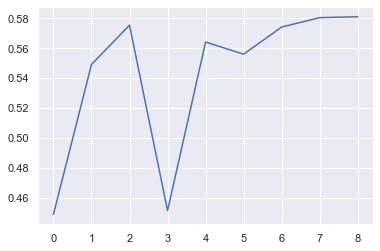

In [414]:
plt.plot(range(len(means)), means)

Не очень понятно, что за прикол с решающим деревом. Ему прямо очень плохо. Но kNN без нормализации еще хуже.

А тут я решила поиграться с логарифмическим нормирование признаков. Оказывается, если отклонение от среднего у признаков меньше, то и отклонение от среднего у моделей предсказания меньше.

In [415]:
wine_new = wine.copy()
wine_new.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [416]:
for col in better_with_log:
    wine_new[col] = np.log(wine_new[col])
for col in better_with_two_logs:
    wine_new[col] = np.log(np.log(wine_new[col]))
wine_new = wine_new.fillna(0)
wine_new.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.693887,-0.356675,0.00,-0.443395,-2.577022,2.397895,3.526361,0.9978,3.51,-0.579818,9.4,5
1,0.719849,-0.127833,0.00,-0.045509,-2.322788,3.218876,4.204693,0.9968,3.20,-0.385662,9.8,5
2,0.719849,-0.274437,0.04,-0.182831,-2.385967,2.708050,3.988984,0.9970,3.26,-0.430783,9.8,5
3,0.882078,-1.272966,0.56,-0.443395,-2.590267,2.833213,4.094345,0.9980,3.16,-0.544727,9.8,6
4,0.693887,-0.356675,0.00,-0.443395,-2.577022,2.397895,3.526361,0.9978,3.51,-0.579818,9.4,5


In [417]:
X, y = wine_new.drop(columns='quality'), wine_new.quality
X_scaled = StandardScaler_.fit_transform(X)

In [418]:
means = []

KNeighborsClassifier_ = KNeighborsClassifier(n_neighbors=10)
score = cross_val_score(KNeighborsClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"KNeighborsClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

StandardScaler_ = StandardScaler()
X_scaled = StandardScaler_.fit_transform(X)
KNeighborsClassifierSS_ = KNeighborsClassifier(n_neighbors=10)
score = cross_val_score(KNeighborsClassifierSS_, X_scaled, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"KNeighborsClassifier, scaled data: {', '.join(map(str, score))}, mean: {score.mean()}")

RidgeClassifier_ = RidgeClassifier(random_state=42)
score = cross_val_score(RidgeClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"RidgeClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

DecisionTreeClassifier_ = DecisionTreeClassifier(random_state=42)
score = cross_val_score(DecisionTreeClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"DecisionTreeClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

BaggingClassifier_ = BaggingClassifier(n_estimators=100, random_state=42)
score = cross_val_score(BaggingClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"BaggingClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

BaggingClassifierHalfF_ = BaggingClassifier(n_estimators=100, max_features=0.5, random_state=42)
score = cross_val_score(BaggingClassifierHalfF_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"BaggingClassifier, half features: {', '.join(map(str, score))}, mean: {score.mean()}")

BaggingClassifierHalfS_ = BaggingClassifier(n_estimators=100, max_samples=0.5, random_state=42)
score = cross_val_score(BaggingClassifierHalfS_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"BaggingClassifier, half samples: {', '.join(map(str, score))}, mean: {score.mean()}")

RandomForestClassifier_ = RandomForestClassifier(n_estimators=100, random_state=42)
score = cross_val_score(RandomForestClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"RandomForestClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

GradientBoostingClassifier_ = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=1, random_state=42)
score = cross_val_score(GradientBoostingClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
means.append(score.mean())
print(f"GradientBoostingClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

KNeighborsClassifier: 0.525, 0.55, 0.50625, 0.521875, 0.567398119122257, mean: 0.5341046238244515
KNeighborsClassifier, scaled data: 0.578125, 0.525, 0.58125, 0.528125, 0.5736677115987461, mean: 0.5572335423197492
RidgeClassifier: 0.60625, 0.515625, 0.578125, 0.55625, 0.6269592476489029, mean: 0.5766418495297806
DecisionTreeClassifier: 0.503125, 0.4625, 0.390625, 0.4125, 0.4670846394984326, mean: 0.4471669278996866
BaggingClassifier: 0.5625, 0.534375, 0.56875, 0.553125, 0.5705329153605015, mean: 0.5578565830721003
BaggingClassifier, half features: 0.61875, 0.540625, 0.571875, 0.546875, 0.554858934169279, mean: 0.5665967868338558
BaggingClassifier, half samples: 0.59375, 0.56875, 0.559375, 0.55, 0.5830721003134797, mean: 0.5709894200626959
RandomForestClassifier: 0.609375, 0.553125, 0.58125, 0.54375, 0.6050156739811913, mean: 0.5785031347962383
GradientBoostingClassifier: 0.590625, 0.575, 0.590625, 0.55625, 0.5893416927899686, mean: 0.5803683385579937


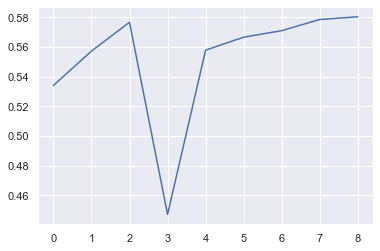

In [419]:
plt.plot(range(len(means)), means)

Лучше стало всем, кроме решающего дерева. Прикол не ясен. Попробую притащить свое решающее дерево и посмотреть, каково ему.

In [420]:
import sys
from collections import Counter


def gini_index(y):
    # для каждого лейбла посчитайте вероятность его появления (нужно просуммировать с помощью numpy
    # значения из y, равные label, то есть y==label, затем поделить их на количество значений в y)
    # затем посчитайте итоговое значение по формуле выше, для возведения в степень используйте numpy
    gini = 0
    n = len(y)
    for label_num in Counter(y).values():
        p = label_num / n
        gini += p**2
    return 1 - gini


def entropy(y):
    # вероятность вычисляется аналогично, для логарифма используйте np.log()
    entr = 0
    n = len(y)
    for label_num in Counter(y).values():
        p = label_num / n
        entr += -p * np.log2(p)
    return entr


class TreeNode:
    def __init__(self, impurity=sys.float_info.max, target_value=None):
        self.left_child = None  # левое ответвление
        self.right_child = None  # правое ответвление
        self.is_leaf = True  # флаг, является ли этот узел терминльным (то есть листом)
        self.target_value = target_value  # значение целевого признака, которое предсказывает этот узел дерева
        self.condition_column = None  # id столбца, по которому будет делаться ветвление в этом узле дерева
        self.condition_value = None  # значение, величины, по которой было сделано ветвление
        self.impurity = impurity  # значение неопределённости для этого узла

    def predict(self, x):
        if self.is_leaf:
            return self.target_value
        mask = x[:, self.condition_column] >= self.condition_value
        res = np.zeros(x.shape[0])
        res[mask] = self.right_child.predict(x[mask])
        res[~mask] = self.left_child.predict(x[~mask])
        return res
    
    
def new_split_impurity(s_left, s_right, impurity_metric):
    n_l, n_r = len(s_left), len(s_right)
    n = n_l + n_r
    answer = n_l / n * impurity_metric(s_left) + n_r / n * impurity_metric(s_right)
    return answer


def find_dominant_class(y):
    return Counter(y).most_common(1)[0][0]


def get_split_values(x):
    # здесь нужно сформировать и вернуть значения, по которым алгоритм будет выбирать значение для разбиения
    # подумайте, как сделать это лучше всего?
    # P.S.: х - это один столбец из характеристических данных
    return np.unique(sorted(x))
        

def find_best_split(x, y, impurity_metric):
    min_impurity = np.inf
    best_split_col = 0
    best_split_value = None
    for col in range(x.shape[1]):
        curr_col = x[:, col]
        for value in get_split_values(curr_col):
            l, r = y[np.argwhere(curr_col < value)].flatten(), y[np.argwhere(curr_col >= value)].flatten()
            impurity = new_split_impurity(l, r, impurity_metric)
            if impurity < min_impurity:
                min_impurity = impurity
                best_split_value = value
                best_split_col = col
    return min_impurity, best_split_col, best_split_value


def build_next_node(x, y, impurity_metric=gini_index):
    t = TreeNode(impurity=impurity_metric(y))
    new_impurity, t.condition_column, t.condition_value = find_best_split(x, y, impurity_metric)
    if len(np.unique(y)) == 1 or new_impurity > t.impurity:
        t.target_value = find_dominant_class(y)
    else:
        t.is_leaf = False
        our_col = x[:, t.condition_column]
        l_x, r_x = np.squeeze(x[np.argwhere(our_col < t.condition_value)]), np.squeeze(x[np.argwhere(our_col >= t.condition_value)])
        if len(l_x.shape) < 2:
            l_x = np.array([l_x])
        if len(r_x.shape) < 2:
            r_x = np.array([r_x])
        l_y, r_y = y[np.argwhere(our_col < t.condition_value)].flatten(), y[np.argwhere(our_col >= t.condition_value)].flatten()
        t.left_child = build_next_node(l_x, l_y, impurity_metric)
        t.right_child = build_next_node(r_x, r_y, impurity_metric)
    return t


class MyDecisionTree:
    def __init__(self):
        self.clf = None
    
    def fit(self, X, y):
        self.clf = build_next_node(X, y)
        
    def predict(self, X):
        return self.clf.predict(X)

In [421]:
np.random.seed(42)

X, y = wine.drop(columns='quality').to_numpy(), wine.quality.to_numpy()

accuracies = []
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = MyDecisionTree()
    clf.fit(X_train, y_train)
    accuracies.append(len(y_test[clf.predict(X_test) == y_test]) / len(y_test))
    
print(f"MyDecisionTreeClassifier: {', '.join(map(str, accuracies))}, mean: {np.mean(accuracies)}")

MyDecisionTreeClassifier: 0.503125, 0.4875, 0.415625, 0.415625, 0.5047021943573667, mean: 0.4653154388714733


Ладно, вывод: решающее дерево очень сильно зависит от того, что ему подавать в качестве тренировочного датасета.

## В моей читалке нет принтскрина. Рубрика "эксперименты"

In [542]:
wine = pd.read_csv('data/winequality-red.csv.gz', sep=';', compression='gzip')
wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<AxesSubplot:>

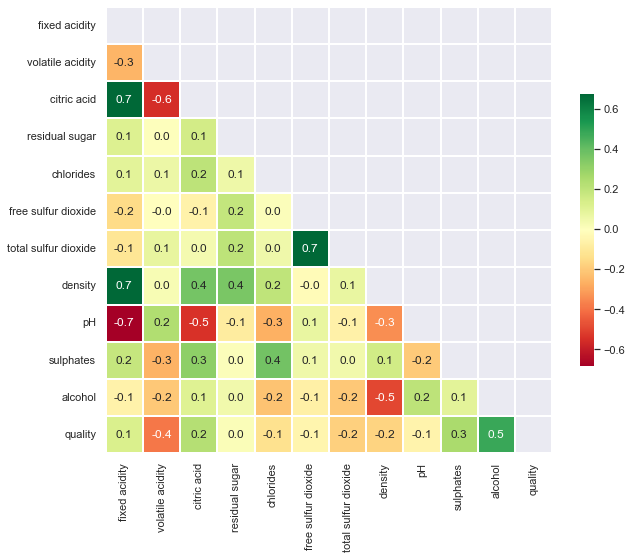

In [543]:
corr = wine.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap='RdYlGn', square=True, cbar=True, cbar_kws={"shrink": .5}, linewidths=.1, mask=mask, annot=True, fmt=".1f")

<AxesSubplot:>

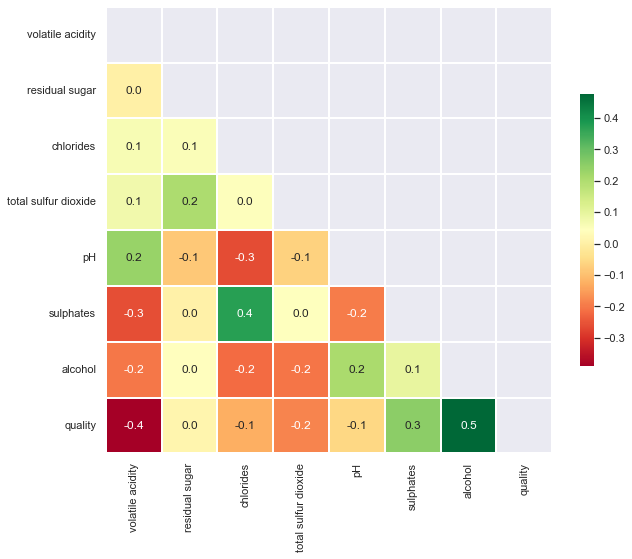

In [544]:
removed_corr = wine.drop(columns=['citric acid', 'fixed acidity', 'free sulfur dioxide', 'density'])
corr = removed_corr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap='RdYlGn', square=True, cbar=True, cbar_kws={"shrink": .5}, linewidths=.1, mask=mask, annot=True, fmt=".1f")

In [545]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = removed_corr.drop(columns='quality'), removed_corr.quality
X, X_val, y, y_val = train_test_split(X, y, test_size=0.4, random_state=42) 

data = X.copy()
data['quality'] = y.copy()

In [546]:
initially_okay = ['density', 'pH', 'quality']
better_with_log = ['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']
better_with_two_logs = ['fixed acidity', 'residual sugar']
just_bad = ['citric acid', 'alcohol']

<AxesSubplot:xlabel='quality', ylabel='count'>

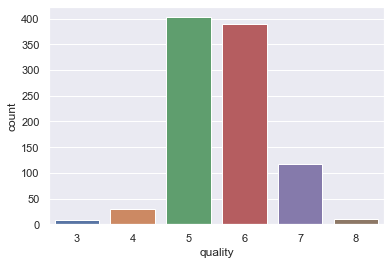

In [547]:
sns.countplot(data.quality)

In [548]:
for col in better_with_log:
    if col in data.index:
        data[col] = np.log(data[col])
for col in better_with_two_logs:
    if col in data.index:
        data[col] = np.log(np.log(data[col]))

In [549]:
three = data[data['quality'] == 3]
four = data[data['quality'] == 4]
seven = data[data['quality'] == 7]
eight = data[data['quality'] == 8]
for _ in range(10):
    data = data.append(three)
    data = data.append(four)
    data = data.append(eight)
for _ in range(10):
    data = data.append(three)
    data = data.append(eight)
for _ in range(6):
    data = data.append(three)
data = data.append(seven)

<AxesSubplot:xlabel='quality', ylabel='count'>

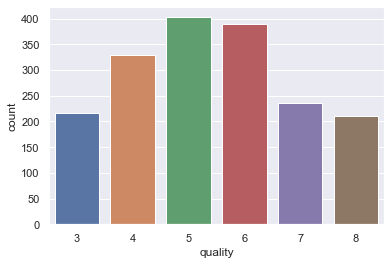

In [550]:
sns.countplot(data.quality)

              precision    recall  f1-score   support

           3       0.38      0.40      0.39        55
           4       0.42      0.32      0.36       100
           5       0.44      0.54      0.49       125
           6       0.34      0.42      0.38       113
           7       0.31      0.23      0.27        77
           8       0.38      0.30      0.34        66

    accuracy                           0.39       536
   macro avg       0.38      0.37      0.37       536
weighted avg       0.38      0.39      0.38       536



<AxesSubplot:>

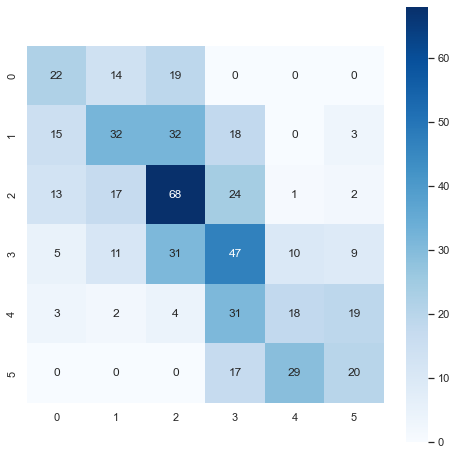

In [551]:
X, y = data.drop(columns='quality'), data.quality
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

In [552]:
GradientBoostingClassifier_ = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=1, random_state=42)
score = cross_val_score(GradientBoostingClassifier_, X, y, cv=KFold(n_splits=5), scoring='accuracy')
print(f"GradientBoostingClassifier: {', '.join(map(str, score))}, mean: {score.mean()}")

GradientBoostingClassifier: 0.4957983193277311, 0.5350140056022409, 0.7254901960784313, 0.5462184873949579, 0.8011204481792717, mean: 0.6207282913165265


              precision    recall  f1-score   support

           3       0.79      1.00      0.88        55
           4       0.67      0.76      0.71       100
           5       0.61      0.48      0.54       125
           6       0.47      0.51      0.49       113
           7       0.70      0.48      0.57        77
           8       0.84      1.00      0.91        66

    accuracy                           0.66       536
   macro avg       0.68      0.71      0.68       536
weighted avg       0.65      0.66      0.65       536



<AxesSubplot:>

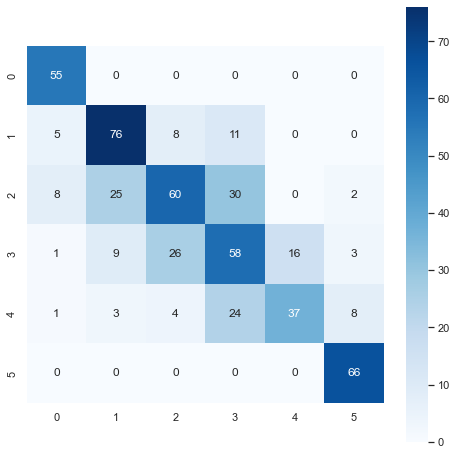

In [553]:
GradientBoostingClassifier_.fit(X_train, y_train)
y_pred = GradientBoostingClassifier_.predict(X_test)

print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.11      0.26      0.15        23
           5       0.68      0.58      0.62       278
           6       0.52      0.48      0.50       248
           7       0.44      0.44      0.44        81
           8       0.18      0.38      0.24         8

    accuracy                           0.50       640
   macro avg       0.32      0.36      0.33       640
weighted avg       0.56      0.50      0.53       640



<AxesSubplot:>

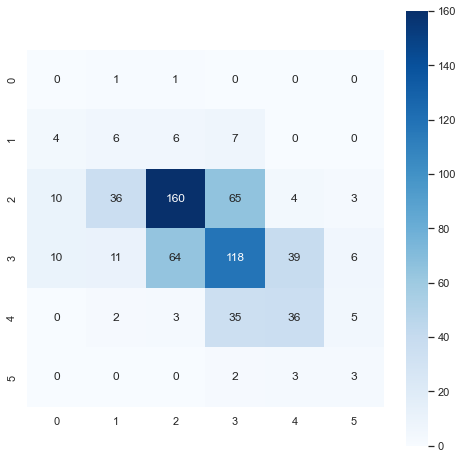

In [554]:
y_pred = GradientBoostingClassifier_.predict(X_val)

print(classification_report(y_val, y_pred))

plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_val, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.3g')

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятсья делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

In [585]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

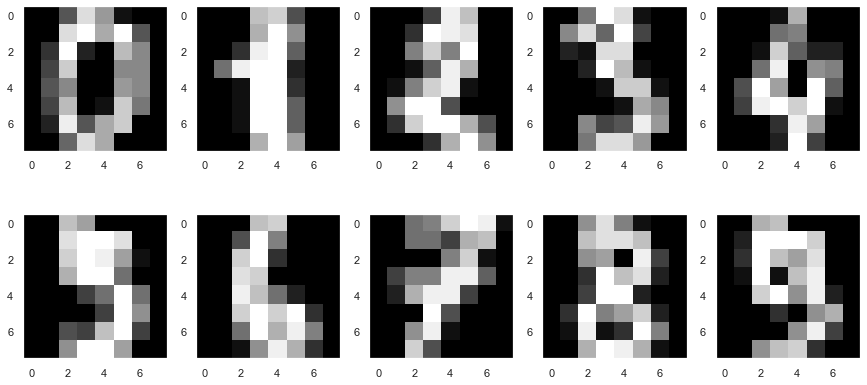

In [586]:
plt.rcParams['axes.grid'] = False
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
for i, picture in enumerate(X[:10]):
    axes[i // 5, i % 5].imshow(picture.reshape(8, 8), cmap='gray')

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [599]:
means = []

DecisionTreeClassifier_ = DecisionTreeClassifier(random_state=42)
score = cross_val_score(DecisionTreeClassifier_, X, y, cv=KFold(n_splits=10), scoring='accuracy')
means.append(score.mean())
print(f"DecisionTreeClassifier: {means[-1]}")

BaggingClassifier_ = BaggingClassifier(n_estimators=100, random_state=42)
score = cross_val_score(BaggingClassifier_, X, y, cv=KFold(n_splits=10), scoring='accuracy')
means.append(score.mean())
print(f"BaggingClassifier: {means[-1]}")

BaggingClassifierSqrtF_ = BaggingClassifier(n_estimators=100, max_features=8, random_state=42)
score = cross_val_score(BaggingClassifierSqrtF_, X, y, cv=KFold(n_splits=10), scoring='accuracy')
means.append(score.mean())
print(f"BaggingClassifier, half features: {means[-1]}")

BaggingClassifierSqrtS_ = BaggingClassifier(n_estimators=100, max_samples=8, random_state=42)
score = cross_val_score(BaggingClassifierSqrtS_, X, y, cv=KFold(n_splits=10), scoring='accuracy')
means.append(score.mean())
print(f"BaggingClassifier, half samples: {means[-1]}")

RandomForestClassifier_ = RandomForestClassifier(n_estimators=100, random_state=42)
score = cross_val_score(RandomForestClassifier_, X, y, cv=KFold(n_splits=10), scoring='accuracy')
means.append(score.mean())
print(f"RandomForestClassifier: {means[-1]}")

DecisionTreeClassifier: 0.830800744878957
BaggingClassifier: 0.9304034761018001
BaggingClassifier, half features: 0.9326505276225948
BaggingClassifier, half samples: 0.7106238361266294
RandomForestClassifier: 0.9515735567970204


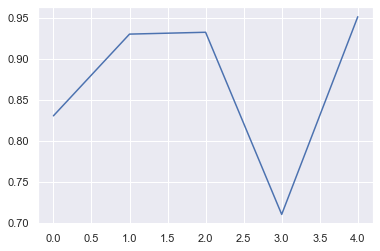

In [604]:
sns.set()
plt.plot(range(len(means)), means)

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

In [601]:
accs = []
for n in [1, 5, 10, 15, 50, 100, 150, 200, 300]:
    RandomForestClassifier_ = RandomForestClassifier(n_estimators=n, random_state=42)
    score = cross_val_score(RandomForestClassifier_, X, y, cv=KFold(n_splits=10), scoring='accuracy')
    accs.append(score.mean())

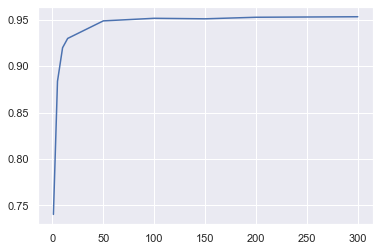

In [603]:
plt.plot([1, 5, 10, 15, 50, 100, 150, 200, 300], accs)

Можно подумать, что чем больше деревьев, тем лучше. Однако, используя elbow method, можно сказать, что наилучшее качество классификации достигается при n ~ 100. Дальше получается переобучение.

### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

In [606]:
accs = []
for n in range(1, 65, 5):
    RandomForestClassifier_ = RandomForestClassifier(n_estimators=100, max_features=n, random_state=42)
    score = cross_val_score(RandomForestClassifier_, X, y, cv=KFold(n_splits=10), scoring='accuracy')
    accs.append(score.mean())

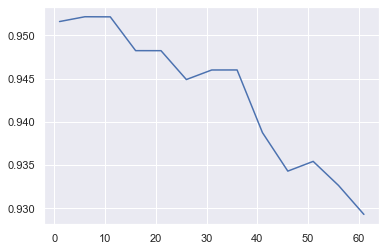

In [607]:
plt.plot(range(1, 65, 5), accs)

Кажется, кого-то оверфитнуло ))

In [608]:
RandomForestClassifier_ = RandomForestClassifier(n_estimators=100, max_features=11, random_state=42)
score = cross_val_score(RandomForestClassifier_, X, y, cv=KFold(n_splits=10), scoring='accuracy')
print(score.mean())

0.9521353196772191
